In [1]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import h5netcdf
import rasterio
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from rasterio.transform import rowcol
from rasterio.windows import from_bounds, Window
from rasterio.windows import bounds as win_bounds
import math
from scipy.stats import gaussian_kde
from shapely.geometry import box
import seaborn as sns
import os

root = Path.cwd()

##### Clean Crown Polygon gpkgs

In [ ]:
## TODO: use file with correct species names (not Hastings)

# these collectively contain 80 out of 105 beech tags
bc = gpd.read_file(root / 'data' / 'harvard' / 'from_repo' / 'beech_gt_jul_15.gpkg')  # july 15 gt: 59 matching tags
bc2 = gpd.read_file(root / 'data' / 'harvard' / 'from_repo' / 'beech_crowns2.gpkg') # july 9 gt: +5 matching tags
tc = gpd.read_file(root / 'data' / 'harvard' / 'from_repo' / 'tree_crowns.gpkg')  # hastings july 15: +16 matching tags

tc4 = gpd.read_file(root / 'data' / 'harvard' /'from_repo' / 'old_crowns.gpkg') # no additional tags
bc3 = gpd.read_file(root / 'data' / 'harvard' / 'from_repo' / 'beech_crowns3.gpkg') # 'ground truthing': no additional tags
tc2 = gpd.read_file(root / 'data' / 'harvard' /'from_repo' /  'tree_crowns2.gpkg')  # hastings july 9: no additional tags
tc3 = gpd.read_file(root / 'data' / 'harvard' / 'from_repo' / 'field_data_crowns.gpkg') # field data: no additional tags

crowns1 = pd.concat([bc,bc2,tc])   

crowns = crowns1.loc[(~crowns1['StemTag'].isna())&(crowns1['StemTag'].str.contains(r'\d')),:].copy()
crowns['StemTag'] = crowns['StemTag'].str.strip()
crowns['StemTag'] = ['0' + x if len(x)==5 else x for x in crowns['StemTag']] 

#crowns_unique = crowns_dropna.loc[~crowns_dropna.duplicated('StemTag'),:].copy()

##### match only beech crowns ######
health = pd.read_excel(root / 'data' / 'harvard' / 'health_census' / 'HF_2025_mortality_census.xlsx',sheet_name='subform_1')
health['StemTag'] = health['StemTag'].astype('str').str.strip()
# add leading 0 to five-digit tags
health['StemTag'] = ['0'+x if len(x)==5 else x for x in health['StemTag']]

######## match mostly non-beech crowns #########
# health = pd.read_excel(root / 'data' / 'harvard' / 'health_census' / 'HF_2024_mortality_census.xlsx',sheet_name='subform_1')
# health['StemTag'] = health['StemTag'].astype('str').str.strip()
# health['StemTag'] = ['0'+x if len(x)==5 else x for x in health['StemTag']]

In [111]:
valid_tags = set(health['StemTag'])

def get_matching_tags(tag_col):
    tags = [t.strip() for t in tag_col.split(',')]
    for t in tags:
        if t in valid_tags:
            if len(t)==5:
                return '0'+ t
            else:
                return t
        else:
            return None

# filter df for just StemTags that also appear in health census
crowns['StemTag'] = crowns['StemTag'].apply(get_matching_tags)

# remove NA and None entries
crowns = crowns.loc[(~crowns['StemTag'].isna())&(~crowns['StemTag'].isin(['None'])),:]

In [112]:
print(f'duplicated polygons: {crowns.duplicated('geometry').sum()}')
print(f'duplicated stem tags: {crowns.duplicated('StemTag').sum()}')

duplicated polygons: 55
duplicated stem tags: 63


In [113]:
# remove duplicate geometry (keep duplicate stem tags bc same stem tag could be associated with mulitple polys)
no_dupe_polys = crowns.drop_duplicates(subset=['geometry'])  
print(f'duplicated polygons: {no_dupe_polys.duplicated('geometry').sum()}')
print(f'duplicated stem tags: {no_dupe_polys.duplicated('StemTag').sum()}')


duplicated polygons: 0
duplicated stem tags: 8


In [ ]:
# write to disk

#TODO: combine beech/all into one file before saving
no_dupe_polys.to_file(root / 'data' / 'harvard' / 'beech_only_crown_polys.gpkg')

#### Get per-pixel crown cover

In [1]:
## read in Sentinel data
t = xr.open_dataarray(root / 'data' / 'harvard' / '2021_harvard_monthly_lowcloud_timeseries_bands.nc')
t1 = t.isel(band=0,time=5)

beech_crowns = gpd.read_file(root / 'data' / 'harvard' / 'beech_crown_polys.gpkg')
beech_crowns['name'] = 'American beech'

tree_crowns = gpd.read_file(root / 'data' / 'harvard' / 'all_tree_crown_polys.gpkg')
tree_crowns['name'] = tree_crowns['name'].fillna('Unknown')
tree_crowns['name'] = tree_crowns['name'].replace('unk','Unknown')

NameError: name 'xr' is not defined

In [ ]:
def get_polygon_fraction_per_pixel(gdf, raster):

    tf = raster.rio.transform()
    width, height = raster.rio.width, raster.rio.height
    xres, yres = raster.rio.resolution()
    pixel_area = abs(xres*yres)

    # candidate pixel window for each tree
    out = []  # rows: (row, col, tree_id, frac, health_weight, etc.)
    for _, r in gdf.iterrows():
        minx, miny, maxx, maxy = r.geometry.bounds
        
        # get pixel rows/column indexes that may overlap polygon
        wind = from_bounds(minx, miny, maxx, maxy, transform=tf)  
        r0, c0 = int(math.floor(wind.row_off)), int(math.floor(wind.col_off)) # starting row/columns
        r1 = int(math.ceil(wind.row_off + wind.height))   #ending row
        c1 = int(math.ceil(wind.col_off + wind.width))    # ending column

        # clip to size of raster
        r0 = max(0,r0)
        c0 = max(0,c0)
        r1 = min(r1,height)
        c1 = min(c1,width)

        for row in range(r0, r1):
            for col in range(c0, c1):
                # get spatial coordinates of pixel
                bw = win_bounds(Window(col_off=col, row_off=row, width=1, height=1), transform=tf)
                # make polygon
                pix = box(*bw)
                # get intersection of tree polygon and pixel polygon
                inter = r.geometry.intersection(pix) 
                if not inter.is_empty:
                    frac = inter.area / pixel_area
                    if frac > 0:
                        out.append((row, col, r['name'], r.StemTag, frac*100))
                    else:
                        out.append('lessthan0')

    df = pd.DataFrame(out,columns=['row','col','species','StemTag','frac'])

    return df

In [ ]:
#TODO: rerun with combined beech/all gpkg
beech_frac_df = get_polygon_fraction_per_pixel(gdf=beech_crowns,raster=t1)

tree_frac_df = get_polygon_fraction_per_pixel(gdf=tree_crowns,raster=t1)


#pixel_polys_df.to_csv(root / 'data' / 'harvard' / 'crown_fractions_sentinel_pixels.csv')
tree_frac_df.to_csv(root / 'data' / 'harvard' / 'all_tree_cover_per_pixel_df.csv')
beech_frac_df.to_csv(root / 'data' / 'harvard' / 'beech_tree_cover_per_pixel_df.csv')

#### Extract spectra for each crown for each year

In [ ]:
## TODO: use combined instead, rather than concatenating at this point

all_frac_df = pd.read_csv(root / 'data' / 'harvard' / 'all_tree_cover_per_pixel_df.csv')
beech_frac_df = pd.read_csv(root / 'data' / 'harvard' / 'beech_tree_cover_per_pixel_df.csv')

# concatenate
frac_df = pd.concat([all_frac_df,beech_frac_df],axis=0)

In [105]:
frac_df['StemTag'].nunique()

989

In [ ]:
h = pd.read_excel(root / 'data' / 'harvard' / 'health_census' / f'HF_2024_mortality_census.xlsx', sheet_name='subform_1')
hh = h.loc[:,['StemTag','crown_intact','crown_living','FAD']]



In [115]:
shared = np.intersect1d(hh['StemTag'].unique(),frac_df['StemTag'].unique())

len(shared)

989

In [ ]:
def extract_spectra_per_pixel(pixel_df, raster, year):

    rows = pixel_df['row'].to_numpy() 
    cols = pixel_df['col'].to_numpy() 

    tt = raster.isel(y=('points',rows),x=('points',cols))  # xarray internally makes a dataarray for indexers

    tt = tt.transpose('points','time','band')

    tt_2d = tt.stack(pixels=('time','band'))

    out_df = tt_2d.to_pandas()

    new_cols = []
    for time_val, band_val in out_df.columns:

        t = pd.Timestamp(time_val).strftime('%b')
        col_name = f'{t}_{band_val}'

        new_cols.append(col_name)

    out_df.columns = new_cols

    df = pd.concat([pixel_df.reset_index(drop=True),out_df.reset_index(drop=True)],axis=1)
    df['StemTag'] = df['StemTag'].astype('int64')

    ### join to health status
    h = pd.read_excel(root / 'data' / 'harvard' / 'health_census' / f'HF_{year}_mortality_census.xlsx', sheet_name='subform_1')
    hh = h.loc[:,['StemTag',f'status_{year}','crown_intact','crown_living','FAD']]
    hh = hh.rename(columns={f'status_{year}':'status'})

    b = pd.read_csv(root / 'data' / 'harvard' / 'health_census' / 'allyears.csv')
    bb = b.loc[b['year']==year,['stem_tag','BBD','BLD']]
    bb = bb.rename(columns={'stem_tag':'StemTag'})

    # only keep stemtags in that year's mortality survey
    per_pix_df = df.merge(hh,on='StemTag',how='inner').merge(bb,on='StemTag',how='left')
    per_pix_df['year'] = year

    # get average pixel reflectance per tree, with pixels weighted by canopy cover (frac)
    avg_cols = [x for x in per_pix_df.columns if '_B' in x]
    # by_tree = per_pix_df.groupby(['year','StemTag']).apply(lambda g: np.average(g[avg_cols], weights=g['frac'], axis=0),include_groups=False)
    # by_tree_df = pd.DataFrame(by_tree.to_list(),index=by_tree.index,columns=avg_cols)
    weighted_sum = per_pix_df[avg_cols].mul(per_pix_df['frac'],axis=0).groupby([per_pix_df['StemTag']]).sum()
    weight_total = per_pix_df.groupby(['StemTag'])['frac'].sum()
    weighted_av = weighted_sum.div(weight_total,axis=0).reset_index()

    species = per_pix_df[['species','StemTag','year']].drop_duplicates('StemTag')

    by_tree_df = weighted_av.merge(species,on='StemTag',how='left')

    # join back to health status
    bbd= bb.drop_duplicates('StemTag')
    hhd = hh.drop_duplicates('StemTag')
    by_tree_df_merge = by_tree_df.merge(hhd,on='StemTag',how='inner').merge(bbd,on='StemTag',how='left')

    return per_pix_df, by_tree_df_merge



In [13]:
all_pix_dfs = []
all_tree_dfs = []

years = [2021, 2022, 2023, 2024, 2025]
for year in years:
    print(year)
    rr = xr.open_dataarray(root / 'data' / 'harvard' / f'{year}_harvard_monthly_lowcloud_timeseries_bands.nc')

    pix_df, tree_df = extract_spectra_per_pixel(frac_df, raster=rr, year=year )

    all_pix_dfs.append(pix_df)
    all_tree_dfs.append(tree_df)

result_perpixel = pd.concat(all_pix_dfs,axis=0)
result_pertree = pd.concat(all_tree_dfs,axis=0)

2021
2022
2023
2024
2025


In [14]:
result_perpixel.to_csv(root / 'data' / 'harvard' / 'per_pixel_monthly_spectra_and_health_all.csv')
result_pertree.to_csv(root / 'data' / 'harvard' / 'per_tree_average_monthly_spectra_and_health_all.csv')

In [138]:
result_pertree.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4945 entries, 0 to 988
Columns: 133 entries, StemTag to status_2025
dtypes: float64(124), int64(2), object(7)
memory usage: 5.1+ MB


In [75]:
result_perpixel['BLD'].unique()

array([nan,  0.,  1.])

In [ ]:




perpixel_df = pd.read_csv(root / 'data' / 'harvard' / 'per_pixel_monthly_spectra_and_health_all.csv')

In [ ]:
pertree_df['BLD'] = pertree_df['BLD'].replace(np.nan,0.0)

In [4]:
beech_tags = pertree_df.loc[pertree_df['year']==2025,'StemTag'].unique()
beechonly_df = pertree_df.loc[pertree_df['StemTag'].isin(beech_tags),:]

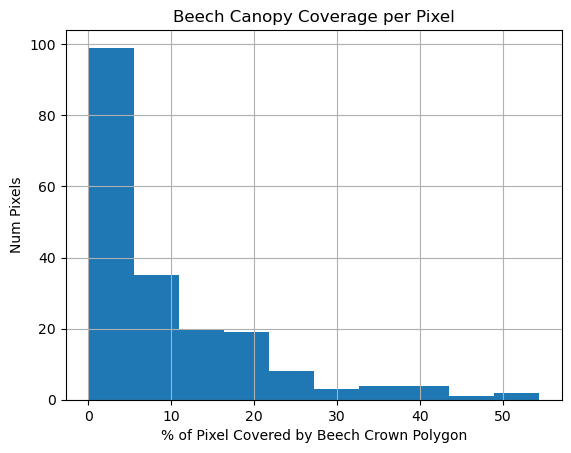

In [ ]:
beech_pixels = perpixel_df.loc[perpixel_df['StemTag'].isin(beech_tags)]
plot_df = beech_pixels.drop_duplicates(['row','col','StemTag'])

ax = plot_df['frac'].hist()

plt.xlabel('% of Pixel Covered by Beech Crown Polygon')
plt.ylabel('Num Pixels')
plt.title('Beech Canopy Coverage per Pixel')

plt.savefig(root / 'figs'/ 'harvard' / 'histogram_beechonly_canopy_coverage_per_pixel.png')
plt.show()

In [5]:

def jm_per_band(x_class1, x_class2, n_points=200):
    x1 = np.asarray(x_class1)
    x2 = np.asarray(x_class2)
    x1 = x1[~np.isnan(x1)]
    x2 = x2[~np.isnan(x2)]

    if len(x1) < 5 or len(x2) < 5:
        return np.nan
  
    #estimate pdfs for both classes
    kde1 = gaussian_kde(x1)
    kde2 = gaussian_kde(x2)

    #get the min/max range for both classes
    lo = min(x1.min(),x2.min())
    hi = max(x1.max(),x2.max())
    x_linspace = np.linspace(lo, hi, n_points)

    #evaluate estimated pdfs for this range
    u = kde1(x_linspace)
    v = kde2(x_linspace)

    # Normalize to integrate to 1
    u /= np.trapezoid(u, x_linspace)
    v /= np.trapezoid(v, x_linspace)

    # Bhattacharyya distance
    bc = np.trapezoid(np.sqrt(u * v), x_linspace)
    B = -np.log(bc + 1e-15)

    # JM distance
    J = 2 * (1 - np.exp(-B))
     
    return J
   

In [ ]:


os.makedirs(root / 'figs' / 'harvard' / 'jm_distance_plots',exist_ok=True)

## we only have beech tree health info for 2025

# get A vs AU for all trees and for just beech trees

# in 2024 and 25 get BLD vs non BLd for beech trees

In [83]:
len(pertree_df) - pertree_df['FAD'].isna().sum()

np.int64(1716)

In [84]:
fad_pertree_df = pertree_df.loc[~pertree_df['FAD'].isna(),:].copy()

In [86]:
def get_fad_classes(df,year,fad):
    if year == 'allyears':
        class1_df = df.loc[df['FAD'].str.contains(fad),:]
        class2_df = df.loc[~df['FAD'].str.contains(fad),:]
    else:
        class1_df = df.loc[(df['FAD'].str.contains(fad))&(df['year'].isin(year)),:]
        class2_df = df.loc[(~df['FAD'].str.contains(fad))&(df['year'].isin(year)),:]
    
    return class1_df, class2_df

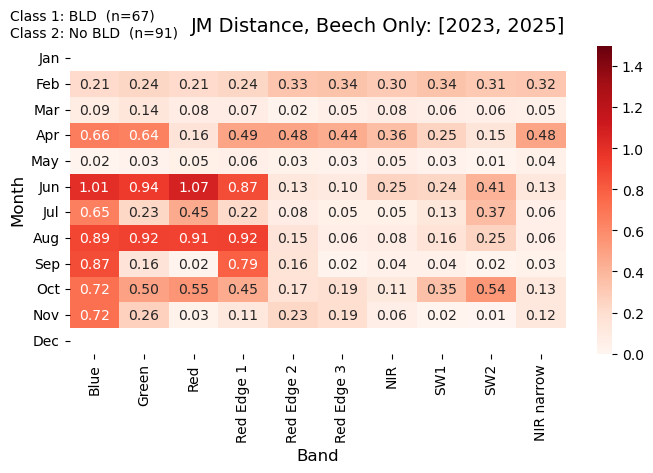

In [ ]:
j_cols = [x for x in pertree_df.columns if '_B' in x]


def get_classes(df,year,class1,class2):
    if year == 'allyears':
        class1_df = df.loc[(df['status'].isin(class1)),:]
        class2_df = df.loc[(df['status']==class2),:]
    else:
        class1_df = df.loc[(df['status'].isin(class1))&(df['year'].isin(year)),:]
        class2_df = df.loc[(df['status']==class2)&(df['year'].isin(year)),:]
    
    return class1_df, class2_df

# year = [2023,2025]
# class1 = ['AU']
# class2 = 'A'

# class1_df, class2_df = get_classes(pertree_df,year=year,class1=class1,class2=class2)

title = 'Beech Only'
filename = 'beechonly'

# year = [2025]
# class1 = 'LF'
# class2 = 'No LF'
# fad = 'LF'
# 
# class1_df, class2_df = get_fad_classes(fad_pertree_df,year=year,fad='DF')

########################################
year = [2023,2025]
class1 = 'BLD'
class2 = 'No BLD'

def get_bld_classes(df,year):
    if year == 'allyears':
        class1_df = df.loc[df['BLD']==1.0,:]
        class2_df = df.loc[(df['BLD']==0.0),:]
    else:
        class1_df = df.loc[(df['BLD']==1.0)&(df['year'].isin(year)),:]
        class2_df = df.loc[(df['BLD']==0.0)&(df['year'].isin(year)),:]
    
    return class1_df, class2_df

class1_df, class2_df = get_bld_classes(beechonly_df,year=year)


############################################

class1_n = len(class1_df)
class2_n = len(class2_df)

jm_values = {}

for j in j_cols:

    jm = jm_per_band(x_class1=class1_df[j],x_class2=class2_df[j])

    jm_values[j] = jm


wide_df = pd.DataFrame(jm_values,index=[0],columns=j_cols)
long_df = wide_df.T.reset_index()
long_df = long_df.rename(columns={'index':'month_band',0:'jm'})
long_df[['month','band']] = long_df['month_band'].str.split('_', expand=True)
pivot_df = long_df.pivot(index='month',columns='band',values='jm')
pivot_df = pivot_df.rename(columns={'B02':'Blue','B03':'Green','B04':'Red','B05':'Red Edge 1','B06':'Red Edge 2','B07':'Red Edge 3','B08':'NIR','B11':'SW1','B12':'SW2','B8A': 'NIR narrow'})

order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
         "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
pivot_df = pivot_df.reindex(order)

# drop nan columns
#pivot_df = pivot_df.dropna(axis=0)

pivot_df = pivot_df.astype('float')

plt.figure(figsize=(8,4))
sns.heatmap(pivot_df, annot=True, cmap='Reds', fmt='.2f',vmin=0,vmax=1.5)

plt.xlabel('Band',fontsize=12)
plt.ylabel('Month',fontsize=12)
plt.yticks(rotation=0)

plt.title(f"JM Distance, {title}: {year}",pad=10,fontsize=14,loc='right')

plt.text(-0.12,1.02,f"Class 1: {class1}  (n={class1_n})\nClass 2: {class2}  (n={class2_n})",ha='left', va='bottom', fontsize=10, transform=plt.gca().transAxes)

plt.savefig(root / 'figs' / 'harvard' / 'jm_distance_plots' / f'jmdistance_heatmap_weightedfracs_{filename}_{year}_{class1}_{class2}.png')

plt.show()


